# PINN codes for Navier stokes and the heat equation

Prathvik G S

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl 
import random

print(tf.__version__)

2.11.0


# 2D Navier stokes equations along with boundary conditions and incompressibility

$$u \frac{\partial{u}}{\partial{x}}+v\frac{\partial{u}}{\partial{y}}=-\frac{1}{\rho}\frac{\partial{p}}{\partial{x}}+\nu(\frac{\partial^2{u}}{\partial{x^2}}+\frac{\partial^2{u}}{\partial{y^2}})$$

$$u \frac{\partial{v}}{\partial{x}}+v\frac{\partial{v}}{\partial{y}}=-\frac{1}{\rho}\frac{\partial{p}}{\partial{y}}+\nu(\frac{\partial^2{v}}{\partial{x^2}}+\frac{\partial^2{v}}{\partial{y^2}})$$

$$\frac{\partial{u}}{\partial{x}}+\frac{\partial{v}}{\partial{y}}=0$$

$$u(x,y)=g(x,y): (x,y) \epsilon d\Omega$$


# The architecture

In [2]:
tf.keras.backend.set_floatx('float32')

#Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(40, activation='tanh'),
    tf.keras.layers.Dense(2)
])

# Custom loss function describing the Navier stokes eqn with boundary conditions and incompressibility

In [5]:
#constants
nu=1/40
lamda=1/(2*nu)-(1/(2*nu)**2+4*np.pi**2)**(0.5)

def dp(x,y):
    return (-lamda*np.e**(2*lamda*x)),0

#loss function for the PINN
def loss(xy,xyb,collo):
    
    with tf.GradientTape(persistent=True) as tape:
        
        
        #loss from the PDE
        x,y=tf.unstack(xy,axis=1)
        tape.watch(x)
        tape.watch(y)
        
        u = model(tf.stack((x,y),axis=1))
        u_pred,v_pred=tf.unstack(u,axis=1)
        
        dudx=tape.gradient(u_pred,x)
        dudy=tape.gradient(u_pred,y)
        
        dvdx=tape.gradient(v_pred,x)
        dvdy=tape.gradient(v_pred,y)
        
        dpdx,dpdy=dp(x,y)
        
        d2udx2=tape.gradient(dudx,x)
        d2udy2=tape.gradient(dudy,y)
        
        d2vdx2=tape.gradient(dvdx,x)
        d2vdy2=tape.gradient(dvdy,y)
        
        
        loss = tf.reduce_mean(tf.square(u_pred*dudx+v_pred*dudy+dpdx-nu*d2udx2-nu*d2udy2))+\
               tf.reduce_mean(tf.square(u_pred*dvdx+v_pred*dvdy+dpdy-nu*d2vdx2-nu*d2vdy2))+\
               tf.reduce_mean(tf.square(dudx+dvdy))
        
        
        #boundary loss
        xb,yb=tf.unstack(xyb,axis=1)
        ub = model(tf.stack((xb,yb),axis=1))
        u_predb,v_predb=tf.unstack(ub,axis=1)
        
        lossb=tf.reduce_mean(tf.square(u_predb-(1-np.e**(lamda*xb)*np.cos(2*np.pi*yb))))+\
          tf.reduce_mean(tf.square(v_predb-((0.5/np.pi)*np.e**(lamda*xb)*np.sin(2*np.pi*yb))))
        
        
        
        '''#100 points from the domain used with the analytic solution as the loss function
        x_c,y_c=tf.unstack(collo,axis=1)
        Uc=model(tf.stack((x_c,y_c),axis=1))
        u_c,v_c,p_c=tf.unstack(Uc,axis=1)
        lossc=tf.reduce_mean(tf.square(u_c-(1-np.e**(x_c)*np.cos(2*np.pi*y_c))))+\
              tf.reduce_mean(tf.square(v_c-((0.5/np.pi)*np.e**(x_c)*np.sin(2*np.pi*y_c))))'''
    
    
    return loss + lossb 


print(nu,lamda)

0.025 -0.9637405441957654


In [6]:
# Define the grid size
N = 30
x_0=-1
x_L=1
y_0=-1
y_L=1

# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, N)
y = np.linspace(y_0, y_L, N)

nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
#nx=2*np.random.rand(100000,1)-1
#ny=2*np.random.rand(100000,1)-1
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)
nx2ny2=tf.convert_to_tensor(nxny, dtype=tf.float32, dtype_hint=None, name=None)

In [7]:
# Define the coordinates of the grid points

'boundary-1'
x = np.linspace(x_0, x_0, 1)
y = np.linspace(y_0, y_L, 50)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny1 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-2'
x = np.linspace(x_L, x_L, 1)
y = np.linspace(y_0, y_L, 50)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny2 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-3'
x = np.linspace(x_0, x_L, 50)
y = np.linspace(y_0, y_0, 1)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny3 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'boundary-4'
x = np.linspace(x_0,x_L, 50)
y = np.linspace(y_L, y_L, 1)
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny4 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

'putting all boundaries in one'
nxnyb=np.concatenate([nxny1,nxny2,nxny3,nxny4],axis=0)
nxbnyb=tf.convert_to_tensor(nxnyb, dtype=tf.float32, dtype_hint=None, name=None)

'feeding in 1% of data solution'

collox=2*np.random.rand(10,1)-1
colloy=2*np.random.rand(10,1)-1
nx, ny = np.meshgrid(collox, colloy, indexing='ij')
nx1=np.reshape(collox,-1)
ny1=np.reshape(colloy,-1)
nxny5 = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)
collo=tf.convert_to_tensor(nxny5, dtype=tf.float32, dtype_hint=None, name=None)

In [8]:
# Define the optimizer

optimizer = tf.keras.optimizers.Adam()

# Train the model
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss_value = loss(nx2ny2,nxbnyb,collo)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss={loss_value:.6f}")


Epoch 0, loss=7.638729
Epoch 100, loss=5.121583
Epoch 200, loss=4.050748
Epoch 300, loss=3.686009
Epoch 400, loss=1.594914
Epoch 500, loss=1.385430
Epoch 600, loss=1.270902
Epoch 700, loss=1.146294
Epoch 800, loss=1.034235
Epoch 900, loss=0.974191


In [10]:
# Define the coordinates of the grid points
x = np.linspace(x_0, x_L, N)
y = np.linspace(y_0, y_L, N)

nx, ny = np.meshgrid(x, y, indexing='ij')
nx, ny = np.meshgrid(x, y, indexing='ij')
nx1=np.reshape(nx,-1)
ny1=np.reshape(ny,-1)
nxny = np.concatenate([nx1[:, None], ny1[:, None]], axis=1)

X=model(nxny)
u,v=tf.unstack(X,axis=1)

# PINN model solution

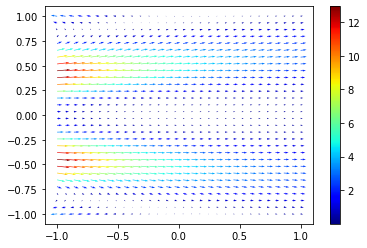

In [11]:
X=model(nxny)
u,v=tf.unstack(X,axis=1)
x_t,y_t=tf.unstack((nxny),axis=1)
M=(u*u+v*v)
qq=plt.quiver(x_t,y_t,u,v,M,cmap=plt.cm.jet)
plt.colorbar(qq, cmap=plt.cm.jet)
plt.show()

# Analytical solution

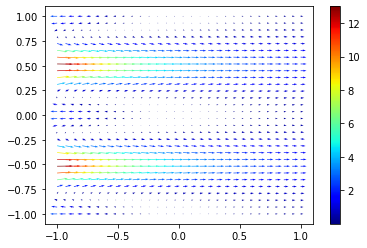

In [12]:
uu=1-np.e**(lamda*x_t)*np.cos(2*np.pi*y_t) 
vv=(0.5/np.pi)*(np.exp(lamda*x_t)*np.sin(2*np.pi*y_t))
M=(uu*uu+vv*vv)
qq=plt.quiver(x_t,y_t,uu,vv,M,cmap=plt.cm.jet)
plt.colorbar(qq, cmap=plt.cm.jet)
plt.show()

$$ \frac{\partial{^2T}}{\partial{x^2}}+\frac{\partial^2{T}}{\partial{y^2}}=0$$

$$T(x=0)=100^o$$

$$T(x=L)=-100^o$$

$$T(y=0)=0^o$$

$$T(y=L)=0^o$$

# Points within the domain

# Points on the boundary